<a href="https://colab.research.google.com/github/evndttr/htr_scripts/blob/main/PAGE_XML_to_Parquet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Extracted 26 line crops


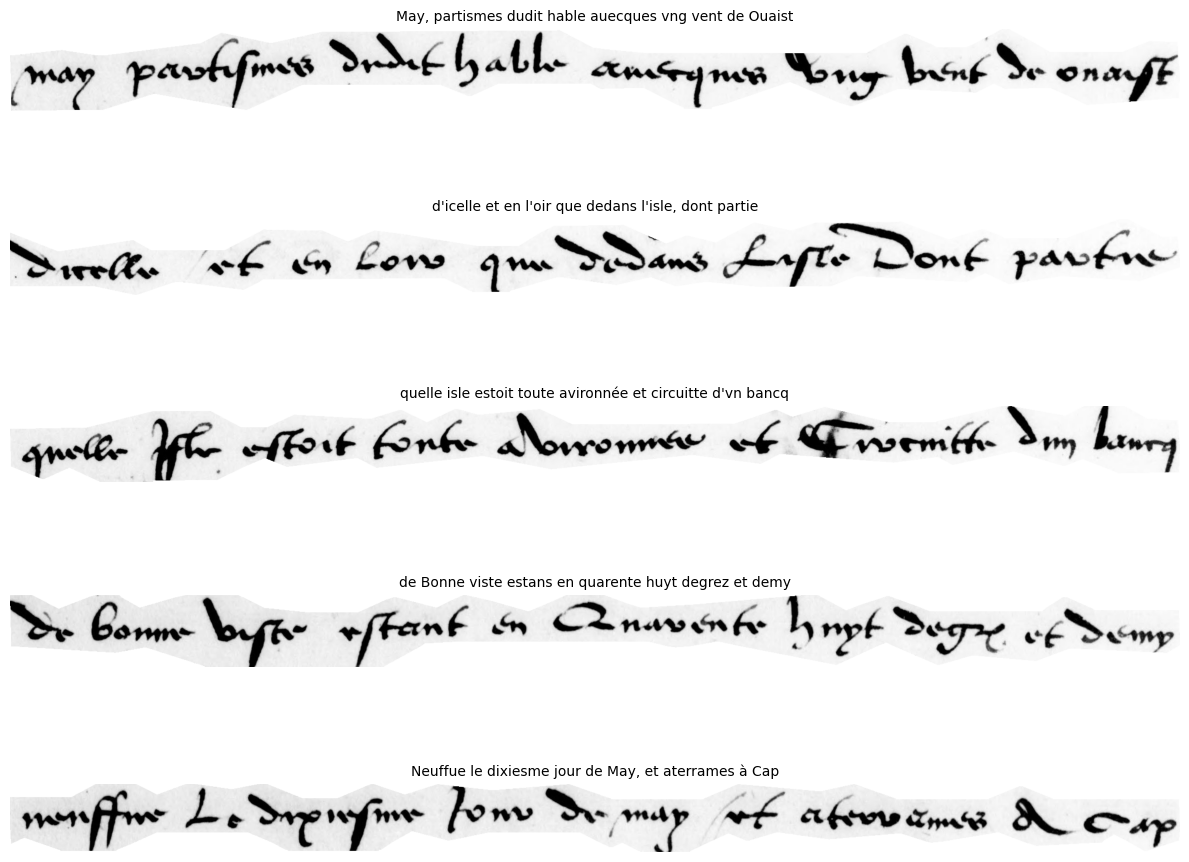

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

5810735

In [2]:
!pip install pillow pandas pyarrow datasets numpy --quiet

import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw
from io import BytesIO
import random
import matplotlib.pyplot as plt
from datasets import Dataset

# === INPUT FILES ===
xml_path = "2.xml"         # your PAGE XML file
image_path = "2.jpg"     # your local image

# --- Parse XML ---
tree = ET.parse(xml_path)
root = tree.getroot()

# Auto-detect namespace from root tag
ns_uri = root.tag.split("}")[0].strip("{")
ns = {"pc": ns_uri}


# --- Load image ---
img = Image.open(image_path).convert("RGB")

records = []

for i, tl in enumerate(root.findall(".//pc:TextLine", ns)):
    coords = tl.find("pc:Coords", ns).get("points")
    pts = [tuple(map(int, p.split(','))) for p in coords.split()]
    xs, ys = zip(*pts)
    xmin, xmax = min(xs), max(xs)
    ymin, ymax = min(ys), max(ys)

    # --- Create mask for ragged edge cropping ---
    mask = Image.new("L", (xmax - xmin + 1, ymax - ymin + 1), 0)
    draw = ImageDraw.Draw(mask)
    shifted_pts = [(x - xmin, y - ymin) for x, y in pts]
    draw.polygon(shifted_pts, outline=255, fill=255)

    # --- Crop region and apply mask ---
    cropped = img.crop((xmin, ymin, xmax + 1, ymax + 1))
    cropped.putalpha(mask)

    # --- Convert image to bytes (for Parquet) ---
    buffer = BytesIO()
    cropped.save(buffer, format="PNG")
    img_bytes = buffer.getvalue()

    # --- Get text ---
    text_el = tl.find("pc:TextEquiv/pc:Unicode", ns)
    text = text_el.text.strip() if text_el is not None and text_el.text else ""

    records.append({
        "id": f"line_{i:04d}",
        "image": img_bytes,
        "label": text
    })

print(f"✅ Extracted {len(records)} line crops")

# --- Preview a few samples ---
sample = random.sample(records, min(5, len(records)))
fig, axes = plt.subplots(len(sample), 1, figsize=(12, 2 * len(sample)))
if len(sample) == 1: axes = [axes]
for ax, rec in zip(axes, sample):
    im = Image.open(BytesIO(rec["image"]))
    ax.imshow(im)
    ax.axis("off")
    ax.set_title(rec["label"], fontsize=10)
plt.tight_layout()
plt.show()

# --- Save to Parquet ---
df = pd.DataFrame(records)
dataset = Dataset.from_pandas(df)
dataset.to_parquet("textline_dataset.parquet")